In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

In [11]:
BASE_DIR = 'UTKFace/'
# Reading all the images present in Base_Dir
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [12]:
# Converting to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,UTKFace/100_0_0_20170112213500903.jpg.chip.jpg,100,0
1,UTKFace/100_0_0_20170112215240346.jpg.chip.jpg,100,0
2,UTKFace/100_1_0_20170110183726390.jpg.chip.jpg,100,1
3,UTKFace/100_1_0_20170112213001988.jpg.chip.jpg,100,1
4,UTKFace/100_1_0_20170112213303693.jpg.chip.jpg,100,1


In [13]:
gender_dict = {0:'Male', 1:'Female'}

In [14]:
df = df.astype({'age':'float32', 'gender': 'int32'})

In [15]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.85, random_state=42)

In [19]:
#Converting Image to numpy array (extracting feature)
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import utils
from keras.preprocessing import image
x_train = []
for file in train.image:
    img = keras.utils.load_img(""+file, grayscale=True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)

In [20]:
x_train.shape
x_train = x_train/255

In [21]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)

# CNN

In [22]:
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
input_size = (128,128,1)
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

In [23]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 126, 126, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Training

In [24]:
history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=20, validation_split= 0.1)

Epoch 1/20
320/320 [==============================] - 186s 567ms/step - loss: 17.1335 - gender_output_loss: 0.7343 - age_output_loss: 16.3991 - gender_output_accuracy: 0.6384 - age_output_accuracy: 0.0491 - val_loss: 26.7346 - val_gender_output_loss: 0.6295 - val_age_output_loss: 26.1051 - val_gender_output_accuracy: 0.6629 - val_age_output_accuracy: 0.0562
Epoch 2/20
320/320 [==============================] - 195s 610ms/step - loss: 13.3193 - gender_output_loss: 0.5331 - age_output_loss: 12.7862 - gender_output_accuracy: 0.7513 - age_output_accuracy: 0.0359 - val_loss: 12.4263 - val_gender_output_loss: 0.5126 - val_age_output_loss: 11.9136 - val_gender_output_accuracy: 0.7444 - val_age_output_accuracy: 0.0478
Epoch 3/20
320/320 [==============================] - 161s 502ms/step - loss: 11.4878 - gender_output_loss: 0.4737 - age_output_loss: 11.0141 - gender_output_accuracy: 0.7756 - age_output_accuracy: 0.0253 - val_loss: 13.6182 - val_gender_output_loss: 0.4383 - val_age_output_loss:

# Visualization

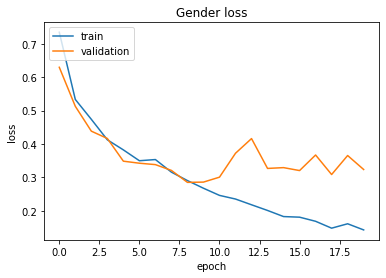

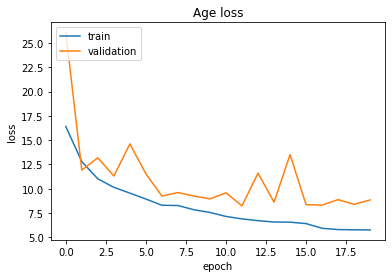

In [25]:
# Plotting the Gender Losses
plt.plot(history.history['gender_output_loss'])
plt.plot(history.history['val_gender_output_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plotting the Age Losses
plt.plot(history.history['age_output_loss'])
plt.plot(history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Predicting 


Original: Gender =  Male  Age =  50.0
1/1 [==============================] - 0s 56ms/step
Prediction: Gender =  Male  Age =  50


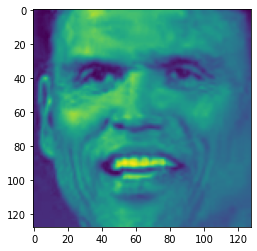

In [27]:
index=20
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128))